Note: figurefirst is a work in progress and should be considered an alpha version. This means  that much of the api, as well as this tutorial is unfinished and likely to change.

In [1]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
#%matplotlib inline
%config InlineBackend.figure_format = 'png' #svg
import matplotlib.pyplot as plt # this notebook is for plotting
#import pylab as plt
import numpy as np
import scipy as sp
import figurefirst as fifi
from IPython.display import display,SVG

def kill_spines(ax):
    return fifi.mpl_functions.adjust_spines(ax,'none', 
                  spine_locations={}, 
                  smart_bounds=True, 
                  xticks=None, 
                  yticks=None, 
                  linewidth=1)

def kill_labels(ax):
    #ax = ax['axis']
    for tl in ax.get_xticklabels() + ax.get_yticklabels():
            tl.set_visible(False)

# Introduction

We generated the ```figurefirst``` library because we found that constructing scientific figures that convey information in a clear, efficient and professional way requires that we pay some attention to details of styling and layout. Although there are a few libraries that seek to improve on the default settings of scientific plotting software, much of this styling is still difficult to specify using text-oriented programing languages, and the process inevitably requires some final adjustment using tools available in vector graphics software such as Inkscape or Adobe Illustrator. The main problem with this workflow is that it is challenging to update data presented in a figure after layout and styling decisions have been made. The ```figurefirst``` library seeks to solve this problem by allowing effort devoted to the raw analysis and raw presentation of data to proceed *in parallel* and *independent to* the work styling and formating the figure. The approach we take is to facilitate passing graphical information from the  <a href="https://www.w3.org/TR/SVG/">open-standard</a> scalable vector graphics (svg) file format into objects consumable by the open-source <a href="http://matplotlib.org/">matplotlib</a> python plotting library.
With `figurefirst` creating a new figure generally involves four steps:

1.	Design the layout file. Fundamentally this means decorating a specific subset of the objects in the svg files with xml tags that identify what objects are something ```figurefirst``` should expose to Python.
2.	Convert the information in the graphical svg objects into python objects. This is accomplished via the ```figurefirst FigureLayout``` class.
3.	Plot your data, taking advantage of the objects created by ```figurefirst``` to style and organize the figure.
4.	Merge your newly created matplotlib figures with the original layout file and save to svg.

As an example, consider constructing a somewhat complicated five-panel figure with non-uniform axes sizes. The  <a href="http://matplotlib.org/users/gridspec.html"> documentation </a> for ```matplotlib.gridspec``` provides one such example:

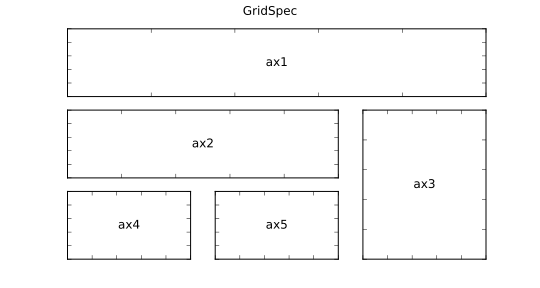

In [3]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize = (7.5,4.0))

def make_ticklabels_invisible(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        for tl in ax.get_xticklabels() + ax.get_yticklabels():
            tl.set_visible(False)

gs = GridSpec(3, 3)
ax1 = plt.subplot(gs[0, :])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0,0), colspan=3))
ax2 = plt.subplot(gs[1,:-1])
ax3 = plt.subplot(gs[1:, -1])
ax4 = plt.subplot(gs[-1,0])
ax5 = plt.subplot(gs[-1,-2])

plt.suptitle("GridSpec")
make_ticklabels_invisible(plt.gcf())
plt.close('all')
fig.savefig('fiveax_gridspec.svg')
display(SVG('fiveax_gridspec.svg'))

To construct a similar plot in figurefirst, we would use Inkscape to draw five boxes in an svg layout document like the one shown below. This layout document would specify the total dimensions of the figure (7.5 by 4.0 in) as well as the placement and aspect ratio of the axes. Also, rather than specifiy the labels progammatically in python we have included them on a separate layer in svg.

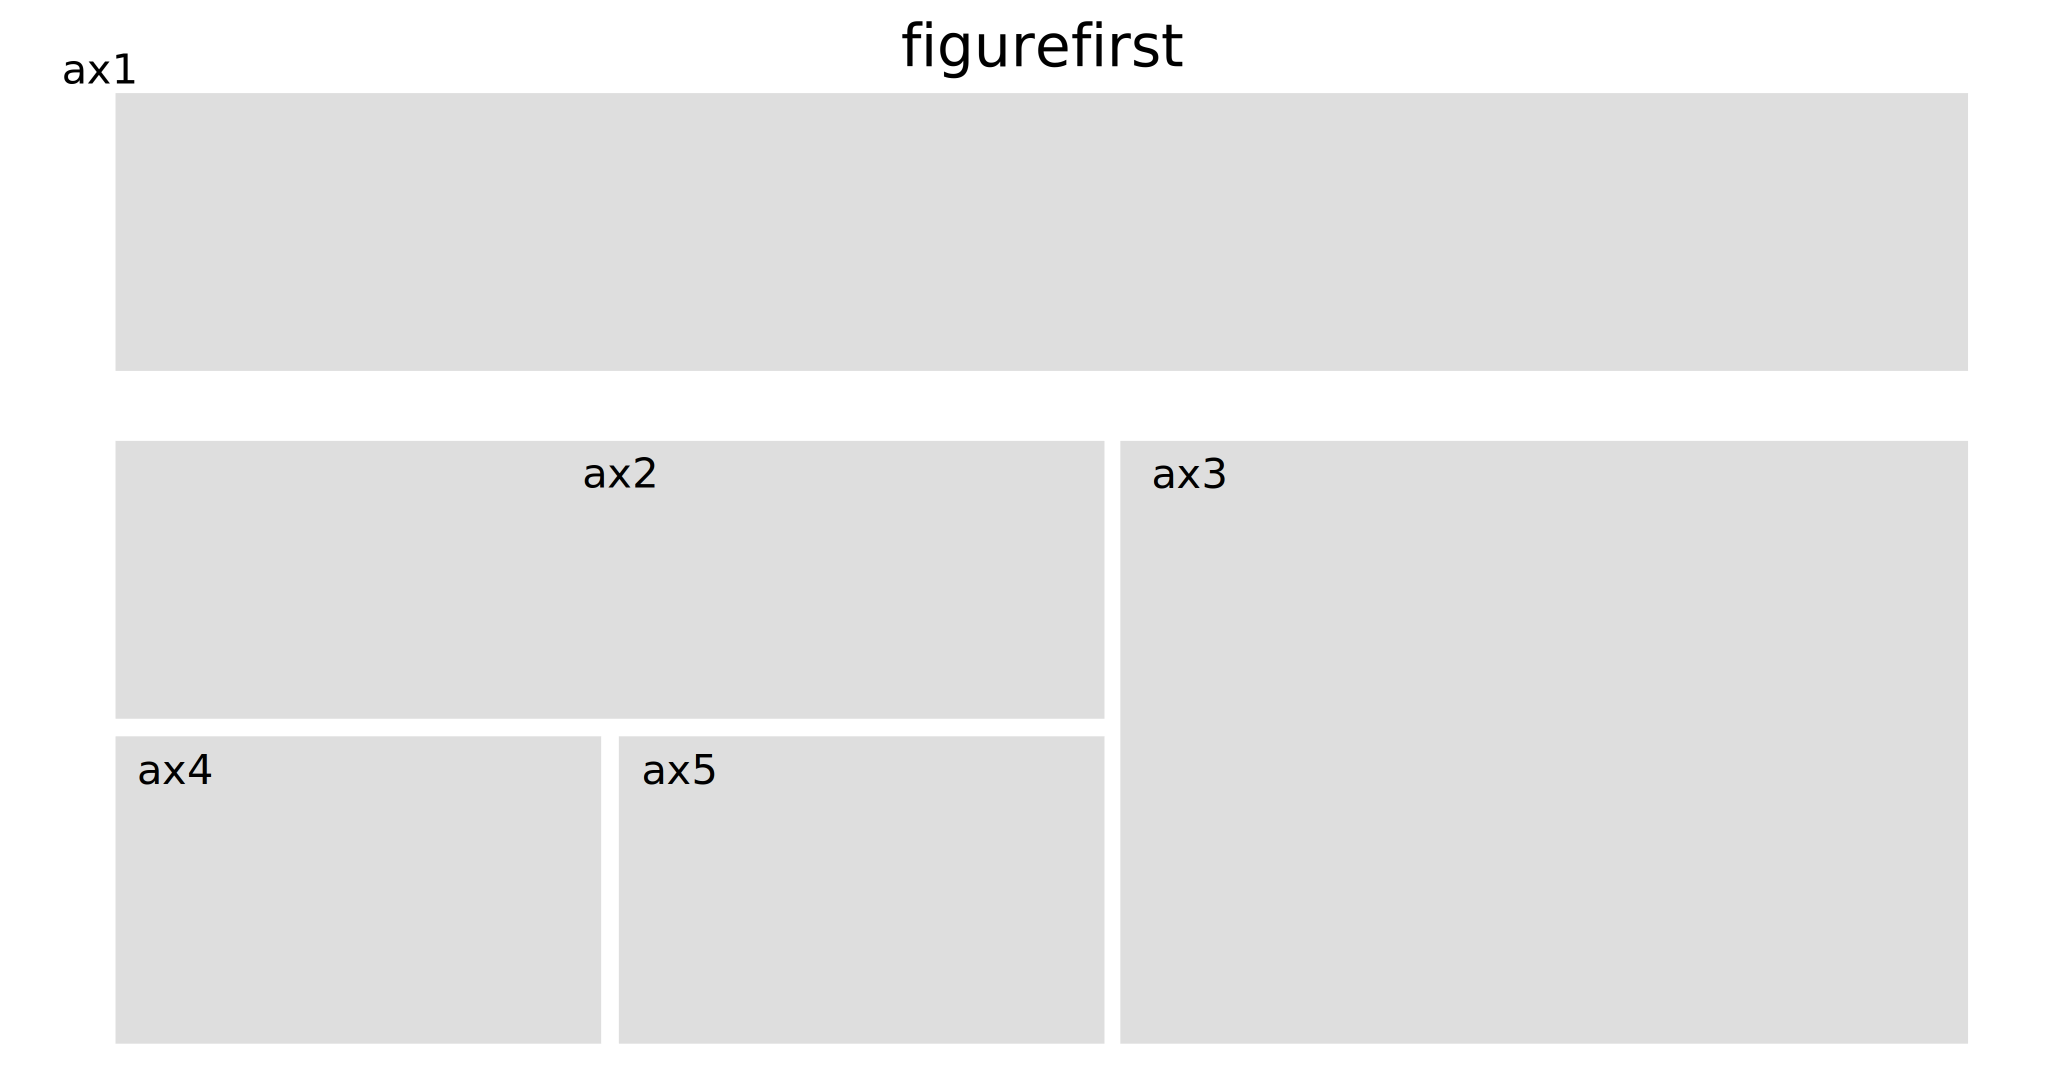

In [4]:
display(SVG('fiveax_layout.svg'))

Note that this is a special .svg file such that the each of these grey boxes has been tagged with some xml that indicates importance to ```figurefirst``` and gives each box a name that will become available in python. We will explain details of this tagging procedure below, however know that we have provided a number of inkscape extensions to streamline the process. You will probably also notice that this layout is a bit different than the output of `GridSpec`: ax2-5 are visually offset from ax1, and the label placement is less-ridged. We have done this pointedly to illustrate an advantage of using a layout. Those with experience using vector graphics packages such as Inkscape will know that graphic elements can be positioned very precisely, and the regular structure produced by `GridSpec` is easily achieved within the context of a layout. The reverse however -- specifying the less regular placement shown in this layout using just python -- would be a bit more difficult.

The block below shows how we would use this layout to make figures:

targetlayer mpl_layer not found inserting into mpltarget


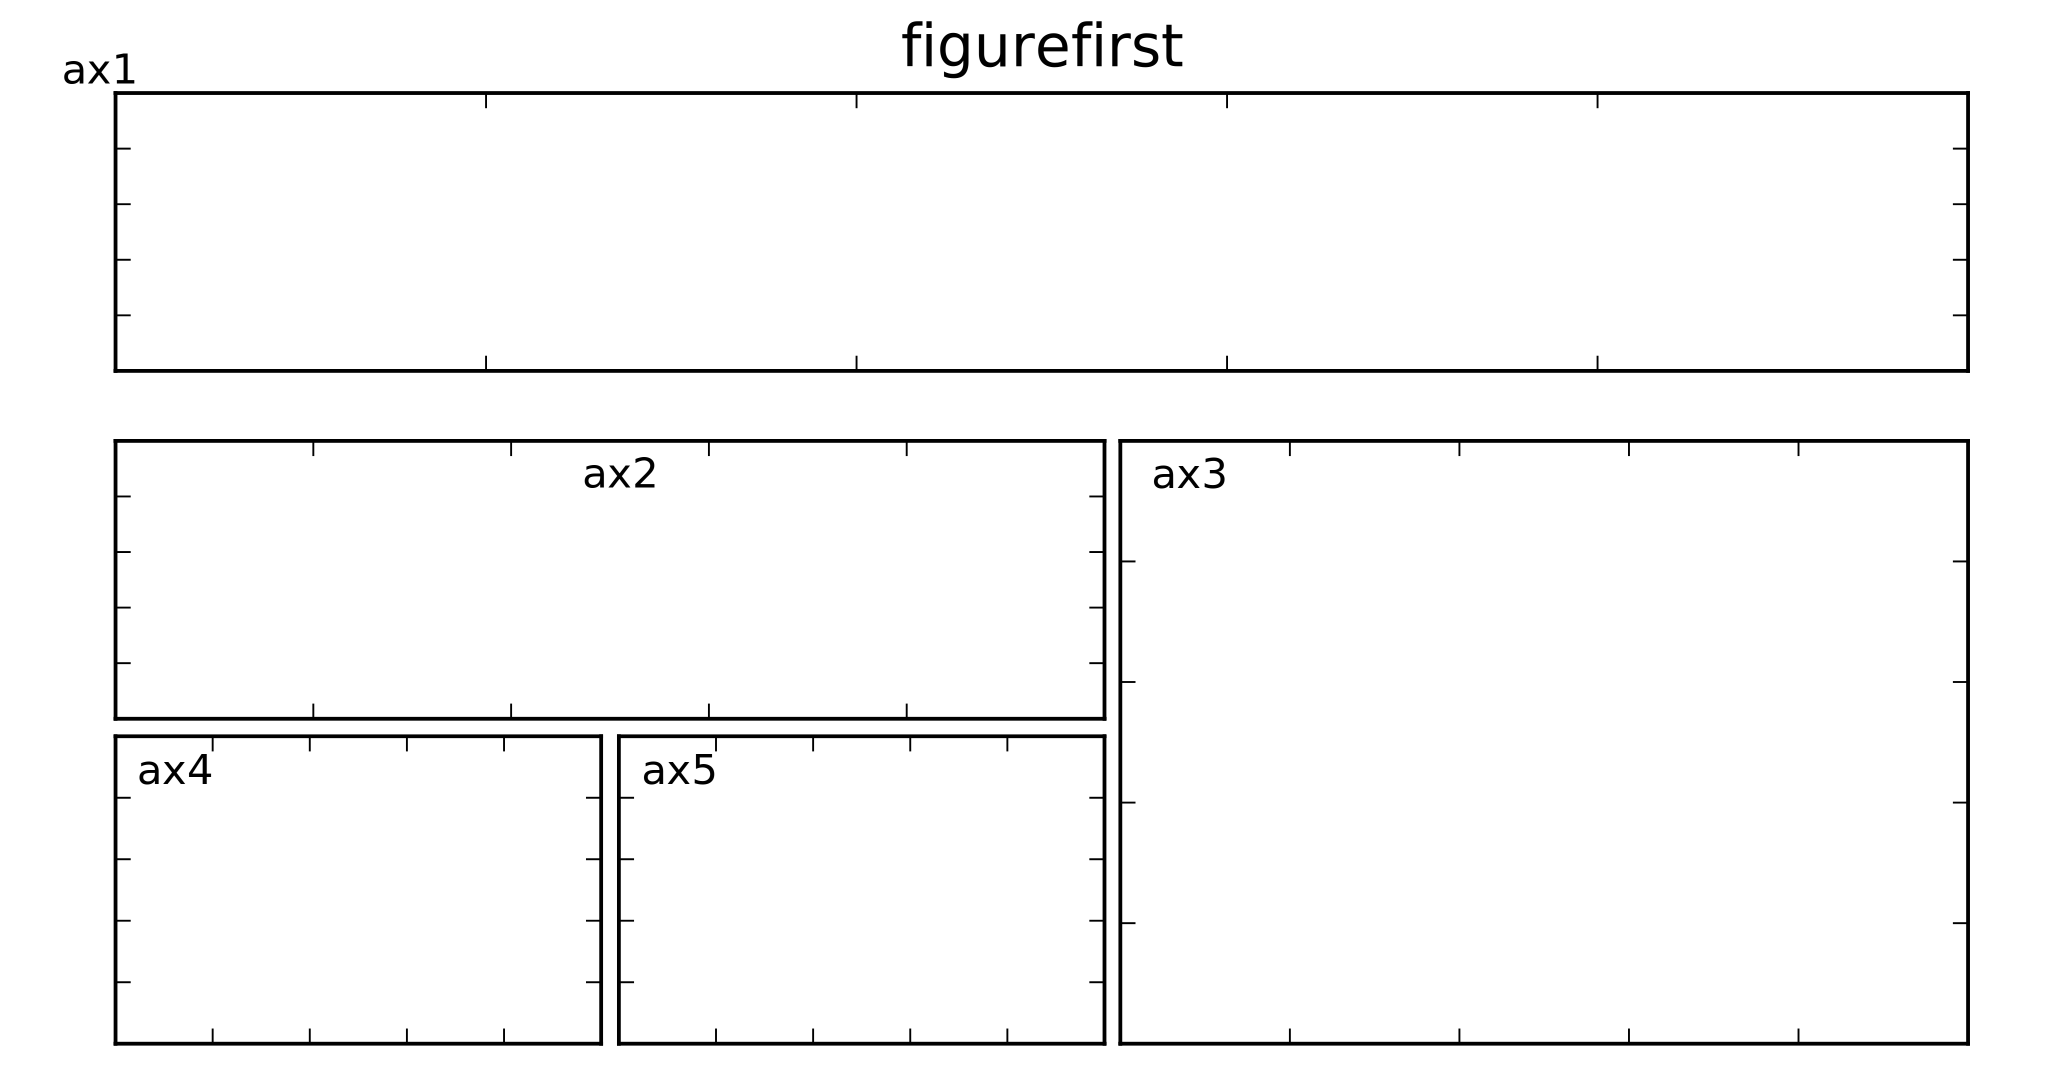

In [5]:
layout = fifi.FigureLayout('fiveax_layout.svg')
layout.make_mplfigures()
[kill_labels(ax) for ax in layout.axes.values()]
layout.insert_figures()
layout.set_layer_visability('Layer 1',False)
layout.write_svg('fiveax_test_output.svg')
plt.close('all')
display(SVG('fiveax_test_output.svg'))

First, in line 1, we pass the name of the layout file to the ```FigureLayout``` constructor, this causes ```figurefirst``` to load the svg from the layout file.

In line 2 we call the ```make_mplfigures()``` method. This generates a matplotlib figure and populates the figure with axes as specified by the layout. 

After the call to ```layout.make_mplfigures()``` we then have access to a dictionary of matplotlib figures in the axes attribute of the layout object. The keys in this dictionary come from the data we passed in via xml. We can then treat these objects like any other maplotlib axis -- plotting data to them if we wish. Here in line 3 we simply pass them to the ```kill_labels()``` function to remove the tick labels.

When we are done plotting and manipulating the axes objects, in line 4 we send the results back into a target svg layer, merging the graphical elements in the layout with those produced by matplotlib in a virtual svg file stored in memory. Since the results of matplotlib get sent into a separate layer, we can remove or hide unwanted elements from the layout like those grey boxes we used to specify the axes using ```layout.set_layer_visability('Layer 1',False)```.

Finally, in line 6 we write the results of the virtual, merged svg file to a new svg document 'fiveax_test_output.svg'.

# Minimal layout document

Although most users will find inkscape to be the most convenient way to create layout documents for `figurefirst`, this is not a hard-and-fast requirement. Indeed, we chose to use svg as the layout file format because, beyond the fact that svg is based on an open-standard, it is a human readable extension of xml that can be edited using nothing more than a text-editor. Since our inkscpe extensions continue to be a work in progress, and it may not always be possible to use inkscape to construct and edit your layout, it is good to have an understaning of the underlying approch we take to construct a layout for `figurefirst`. First, consider the contents of a simple .svg file:

``` xml 
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   width="7.5in"
   height="4in"
   viewBox="0 0 675.000 360.000"
   id="svg2"
   version="1.1">
  <rect
     id="rect4703"
     width="615.0"
     height="300.0"
     x="30.0"
     y="30.0"
     style="fill:#cccccc;stroke:none;">
  </rect>
</svg>
```

We will explain how to convert this file into a layout, but it is worth pointing out a few features of the svg format itself. 

The first line declares the type of xml file. Next, we find the tag specifying the beginning of the svg element which has a number of important attributes. First are a series of standard xml namespace declarations, though you do not need to worry about these declarations, you will need to add a line here to construct a `figurefirst` layout. Following the `xmlns` attributes are the svg `height` and `width` attributes. These provide the dimensions of the svg file and your final figure. These can be specified in cm,mm and in. Next is the `viewBox` attribute. The `viewBox` determines the transformation from the units specified in `height` and `width` into something known as 'user units'. These user units will be used throught the svg document to specify the height, width and position of the graphical elements. In this example, we have chosen a scaling of 90 user units per inch. This happens to be the si definition for a typseting point, and is the default setting for inkscape, but keep in mind that this is arbitrary, and can be anything. The only restriction that `figurefirst` makes is that the aspect ratio of the `viewBox` is eqivilent to the aspect ratio given by `height` and `width` and that the first two elements of the `viewBox` are set to 0. In most cases you will not need to worry about this, but is worth mentioning in case you need to troubleshoot.

Within the svg element we find one graphical element, a `<rect>`. The attributes of this `<rect>` specify width, height, x and y position which we will ultimately use to specifiy the positon and size of an axis in the matplotlib figure. In this case, the rect is 7 2/3 inches wide and 3 1/3 in tall and begins 1/3 of an inch in from the top left of the figure. Additionally, the `<rect>` has an xml id (inkscape requires that this be unique throught the document) and a style attribute that can be used to specify (among other things) the stroke and fill of the rectangle. Later we will show you how can pass style data such as this into matplotlib to style the lines and fills within your plots, but for the moment the style string is only important to provide the rect with a stroke or fill so that you man visualize the placement of the axes in your layout.

If we save this as 'min_layout.svg' and render the image using a svg editor or web browser we should should see a nice gray box with a white border around it:

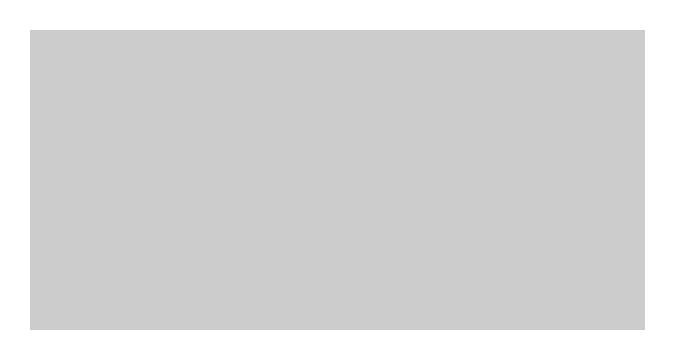

In [6]:
display(SVG('min_svg.svg'))

To make this svg document something we can use with `figurefirst` we need to add a few lines to our svg file. First we need to append the namespace declarations to add  `figurefirst` and  inkscape.
``` xml
<svg
    xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
    xmlns:svg="http://www.w3.org/2000/svg"
    xmlns="http://www.w3.org/2000/svg"
    xmlns:figurefirst="http://flyranch.github.io/figurefirst/"
    xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
    ...
    
``` 
Second, we need to tag the `<rect>` to identify it as an axis by adding a `figurefirst:axis` element so that it is enclosed between `<rect>` and `</rect>`.

```xml
    ....
  <rect
     id="rect4703"
     width="615.0"
     height="300.0"
     x="30.0"
     y="30.0"
     style="fill:#cccccc;stroke:none;">
    <figurefirst:axis
       figurefirst:name="axis1"/>
    </rect>
    ...
```

Note that the `figurefirst:axis` has a `figurefirst:name` attribute. This will identify the axis for us in python. 

Finally, we need to add a target layer for the matplotlib output with the `<figurefist:targetlayer>` tag.

``` xml
  ...
  <g
     inkscape:groupmode="layer"
     id="layer1"
     inkscape:label="Layer 1" >
     <figurefirst:targetlayer
         figurefirst:name='mpl_layer'/>
   </g>
  ...
```
Now we can save this as 'min_layout.svg' and use it to plot.

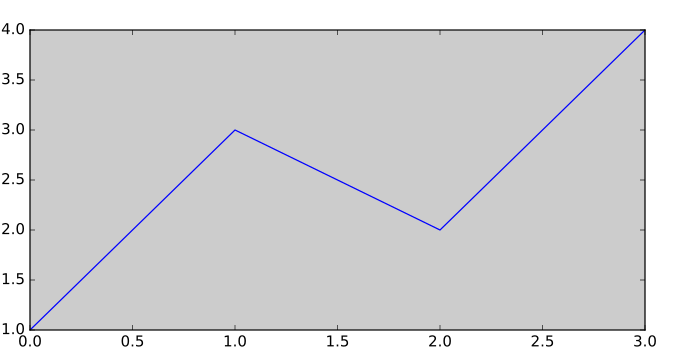

In [7]:
layout = fifi.FigureLayout('min_layout.svg')
layout.make_mplfigures()
layout.axes['axis1'].plot([1,3,2,4])
layout.insert_figures()
layout.write_svg('min_test_output.svg')
plt.close('all')
display(SVG('min_test_output.svg'))

In [82]:
def flatten_list(container):
    for i in container:
        if isinstance(i, (list)):
            for j in flatten_list(i):
                yield j
        else:
            yield i
    #from hexparrot @ http://stackoverflow.com/questions/10823877/
    #what-is-the-fastest-way-to-flatten-arbitrarily-nested-lists-in-python 

def flatten_dict(d):
    import copy
    keylist = [] 
    def traverse(kl,d):
        if len(d) == 0:
            yield {tuple(kl):d}
        else:
            for key,value in d.items():
                new_keylist = copy.copy(kl)
                new_keylist.append(key)
                yield [l for l in traverse(new_keylist,value)]
    flat_dict = {}
    fd_list = [fd for fd in flatten_list(list(traverse(keylist,d)))]
    [flat_dict.update(fd) for fd in flatten_list(list(traverse(keylist,d)))]
    return flat_dict

class FFItem(dict):
    def __init__(self,tagnode,**kwargs):
        self.tagnode = tagnode
        self.node = tagnode.parentNode
        self.id = self.node.getAttribute('id')
        self.name = tagnode.getAttribute('figurefirst:name')
        self.ismplaxis = False
        if self.node.hasAttribute('transform'):
            self.transform_str = self.node.getAttribute('transform')
        else:
            self.transform_str = None
        super(FFItem, self).__init__(**kwargs)
        
class FFGroup(FFItem):
    def __getattr__(self,attr):
        pnts = np.vstack([np.array([np.array([i.x,i.y]),np.array([i.x+i.w,i.y+i.h])])
                          for i in self.values()])
        x = np.min(pnts[:,0])
        y = np.min(pnts[:,1])
        w = np.max(pnts[:,0])-x
        h = np.max(pnts[:,1])-y
        try:
            return {'x':x,'y':y,'w':w,'h':h}[attr]
        except KeyError:
            return self.__getattribute__(attr)

class FFTemplateTarget(FFItem):
    def __init__(self,tagnode,**kwargs):
        self.template_source =  kwargs.pop('template',None)
        super(FFItem, self).__init__(tagnode,**kwargs)

class FFFigure(FFGroup):
    pass
    
class FFAxis(FFItem):
    def __init__(self,tagnode,**kwargs):
        super(FFAxis, self).__init__(tagnode,**kwargs)
        x = float(self.node.getAttribute('x'))
        y = float(self.node.getAttribute('y'))
        h = float(self.node.getAttribute('height'))
        w = float(self.node.getAttribute('width'))
        self.p1 = np.array([x,y,1])
        self.p2 = np.array([x+w,h+y,1])
        
    def __getattr__(self,attr):
        if attr == 'x':
            return self.p1[0]
        if attr == 'y':
            return self.p1[1]
        if attr == 'w':
            return (self.p2-self.p1)[0]
        if attr == 'h':
            return (self.p2-self.p1)[1]
        else:
            if self.ismplaxis:
                return self['axis'].__getattribute__(attr)
            else:
                return self.__getattribute__(attr)
            
def parse_transform(transform_str):
    """convert transforms into transformation matrix"""
    #print transform_str
    import re
    # regex for extracting numbers from transform string
    scanfloat =  r"[+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)?" 
    tr = None;tr_pos = None
    mt = None;mt_pos = None
    sc = None;sc_pos = None
    ##################
    if 'translate' in transform_str:
        translate_str = re.findall(r'translate\(.*?\)',transform_str)[0]
        tx,ty = re.findall(scanfloat,translate_str)
        tr = np.array([[1.,0,float(tx)],
                       [0,1.,float(ty)],
                       [0,0,1.        ]])        
        tr_pos = transform_str.find('translate')
    ##################    
    if 'scale' in transform_str:
        translate_str = re.findall(r'scale\(.*?\)',transform_str)[0]
        sx,sy = re.findall(scanfloat,translate_str)
        sc = np.array([[float(sx),0,         0],
                       [0,        float(sy), 0],
                       [0,        0,        1.]])
        sc_pos = transform_str.find('scale')
    ##################
    if 'matrix' in transform_str:
        matrix_str = re.findall(r'matrix\(.*?\)',transform_str)[0]
        a,b,c,d,e,f = re.findall(scanfloat,matrix_str)
        a,b,c,d,e,f = [float(s) for s in [a,b,c,d,e,f]]
        mt = np.array([[a,c,e],
                       [b,d,f],
                       [0,0,1.]])
        mt_pos = transform_str.find('matrix')
    ##################
    trnsfrms = [mtrx for (pos,mtrx) in sorted(zip([tr_pos,mt_pos,sc_pos],
                                              [tr,mt,sc]))]
    trnsfrms = [m for m in trnsfrms if not(m is None)]
    from numpy import dot
    from functools import reduce
    if len(trnsfrms) > 1:
        mtrx = reduce(lambda x,y:dot(x,y.T),trnsfrms)
    return mtrx 

def get_transforms(node,tlist = []):
    if node.hasAttribute('transform'):
        #print node.toxml()
        tlist.extend([parse_transform(node.getAttribute('transform'))])
    if not(node.nodeName == 'svg'):
        return get_transforms(node.parentNode,tlist)
    else:
        return([t for t in tlist if not(t is None)])
    
def make_group_tree(layout):
    def traverse(node,grouptree):
        gname = None
        axname = None
        tree_loc = grouptree
        for child in node.childNodes:
            if child.nodeType == 1:
                if child.tagName in ['figurefirst:group']:
                    grp = FFGroup(child)
                    grouptree[grp.name] = grp
                    tree_loc = grouptree[grp.name]
                if child.tagName in ['figurefirst:axis']:
                    ax = FFAxis(child)
                    grouptree[ax.name] = ax
                    mpl_methods_elements = node.getElementsByTagName('figurefirst:mplmethods')
                    mpl_methods = dict()
                    grouptree[ax.name].mplmethods = mpl_methods
                    for mpl_methods_element in mpl_methods_elements:
                        [grouptree[ax.name].mplmethods.update({key:value}) for key,value in mpl_methods_element.attributes.items()]
                    projection = node.getElementsByTagName('figurefirst:projection')
                    if len(projection) == 0:
                        grouptree[ax.name].projection = 'rectilinear'
                    else:
                        grouptree[ax.name].projection = projection
                if child.tagName in ['figurefirst:figure']:
                    if node.hasAttribute('figurefirst:template'):
                        fig = FFTemplateTarget(child)
                        grouptree[fig.name] = fig
                    else:
                        fig = FFFigure(child)
                        grouptree[fig.name] = fig
                        tree_loc = grouptree[fig.name]
                    
        for child in node.childNodes:
            if child.hasChildNodes():
                traverse(child,tree_loc)
    ### Create the group tree
    grouptree = dict()
    traverse(layout.layout,grouptree)
    leafs = flatten_dict(grouptree)
    #print [leaf.node for leaf in leafs]
    ### Create the figure tree
    figuretree = dict()
    figuretree['none'] = dict()
    for val in grouptree.values():
        if type(val) == FFFigure:
            figuretree[val.name] = val
        else:
            figuretree['none'][val.name] = val
    ### Compose the transforms 
    from numpy import dot
    from functools import reduce
    for leaf in leafs.values():
        tlist = get_transforms(leaf.node,[])
        tlist.reverse()
        leaf.tlist = tlist
        if len(tlist) > 0:
            mtrx = reduce(lambda x,y:dot(x,y),tlist)
        leaf.mtrx = mtrx
        leaf.p1 = np.dot(mtrx,leaf.p1)
        leaf.p2 = np.dot(mtrx,leaf.p2)
        #svg origin is at top left
        leaf.p1[1] = layout.layout_uh-leaf.p1[1]
        leaf.p2[1] = layout.layout_uh-leaf.p2[1]
        ### add error condition for points that are outside the figure bounds
    ### Need to implement the template target
    new_leafs = dict()
    for key,value in leafs.items():
        if len(key) ==1:
            new_leafs[key[0]] = value
        else:
            new_leafs[key] = value
    return figuretree,grouptree,new_leafs

def makemplfigures(figuretree):
    for figname,figgroup in figuretree.items():
        leafs = flatten_dict(figgroup)
        fw_in = fifi.tounit(layout.layout_width, 'in')
        fh_in = fifi.tounit(layout.layout_height, 'in')
        fig = plt.figure(figsize=(fw_in, fh_in))
        for leafkey,leaf in leafs.items():
            left = leaf.x/layout.layout_uw
            width = leaf.w/layout.layout_uw
            height = leaf.h/layout.layout_uh
            bottom = leaf.y/layout.layout_uh
            leaf['axis'] = fig.add_axes([left, bottom, width, height])
            leaf['figname'] = figname
            leaf.ismplaxis = True
            #figuretree['figure'] = (u'top_group', u'group2', u'ax1'): {}, (u'ungrouped',): {}, (u'group1', u'ax1'): {}, (u'top_group', u'group2', u'ax2'): {}, (u'top_group', u'group1', u'ax2'): {}, (u'top_group'fig
            figgroup['figure'] = fig

In [83]:
layout = fifi.FigureLayout('nested_groups_layout.svg')
figuretree,grouptree,leafs = make_group_tree(layout)
makemplfigures(figuretree)
[l.plot([1,2,3,4]) for l in leafs.values()]
[layout.append_figure_to_layer(fig['figure'],'mpl_layer') for fig in figuretree.values()]
layout.write_svg('nested_groups.svg')

In [84]:
leafs.keys()

[(u'fig2', u'group3', u'ax1'),
 (u'top_group', u'group1', u'ax2'),
 (u'group1', u'ax1'),
 (u'top_group', u'group1', u'ax1'),
 (u'group1', u'ax2'),
 u'ungrouped',
 (u'top_group', u'group2', u'ax1'),
 (u'top_group', u'group2', u'ax2'),
 (u'fig2', u'group3', u'ax2')]

In [688]:
#regex for finding all tags <figurefirst:axis([\s\S]*?)>

In [689]:
print groups['cohort1']['groupA']['ax1'].node.toprettyxml()

<rect height="64.649765" id="rect3336" style="fill:#999999" width="131.31982" x="18.822842" y="715.09308">
	
          
	<figurefirst:axis figurefirst:name="ax1"/>
	
        
</rect>



In [690]:
tlist = [np.array([[  1.      ,   0.      ,  28.      ],
           [  0.      ,   1.      ,   8.672627],
           [  0.      ,   0.      ,   1.      ]]),
 np.array([[   1.     ,    0.     ,    0.     ],
           [   0.     ,    1.     , -692.36217],
           [   0.     ,    0.     ,    1.     ]])],

In [691]:
 -692.36217+8.672627

-683.689543

In [692]:
7.5/675.00

0.011111111111111112

In [693]:
print groups['cohort1']['groupA']['ax1'].h * 0.011111111111111112

0.718330722222


In [694]:
print groups['cohort1']['groupA']['ax1'].y 

715.09308


31.403537


In [680]:
print leafs[(u'cohort1', u'groupA', u'ax1')].y * 0.011111111111111112

0.348928188889


In [681]:
t1 =  leafs[(u'cohort1', u'groupA', u'ax1')].tlist[0]

t2 =  leafs[(u'cohort1', u'groupA', u'ax1')].tlist[1]

In [682]:
np.dot(t2,t1)

array([[   1.      ,    0.      ,   28.      ],
       [   0.      ,    1.      , -683.689543],
       [   0.      ,    0.      ,    1.      ]])

In [651]:
715+683.689543 * 0.011111111111111112

722.5965504777778

In [394]:
print groups['cohort1']['groupA']['ax1'].y

715.09308


In [32]:
groups['cohort2']['groupA']

AttributeError: 'FFItem' object has no attribute 'x'

In [31]:
groups['cohort2']['groupA']['ax1'].transform_mtrx
print groups['cohort2']['groupA']['ax1'].x
print groups['cohort2']['groupA']['ax1'].y
print groups['cohort2']['groupA']['ax1'].w
print groups['cohort2']['groupA']['ax1'].h

18.822842
715.09308
131.31982
64.649765


In [385]:
sstring  = 'bla bla translate(28,8.672627) bla bla'

In [394]:
re.findall(r'translate\(.*\)',sstring)

['translate(28,8.672627)']

In [483]:
groups.__dict__

{'gid': None, 'name': None, 'node': None, 'transform': None}

In [383]:
re.findall(expr,'translate(28,8.672627)')

['28', '8.672627']

# Using inkscape extensions to prepare a layout
- setting up namespace and units
- tagging axes
- setting up target layer

# Tricks and tips
- Using groups to control flow in plotting code
- Itteratative design

# Passing axis methods

You can decorate the ```svg <figurefirsrt:axis>``` tag with ```mpl.axis``` methods. For example to call:

```python
ax.axhspan(100,200,zorder=10,color ='r',alpha = 0.3)
``` 

on the axis named ```frequency.22H05.start``` use the following tag:

```xml
<figurefirst:axis
     figurefirst:name="frequency.22H05.start"
     figurefirst:axhspan="100,200,zorder=10,color='r',alpha=.3"/> ```
     
The layout.apply_mpl_methods function will then apply the methods passing the value of the svg atribute as arguments to the ```mpl.axis``` method.

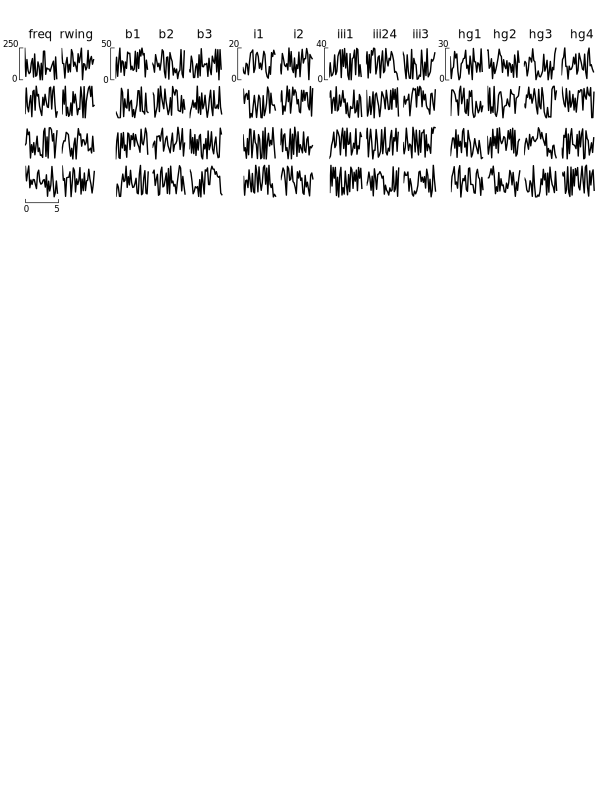

In [8]:
#Passing axis methods
import numpy as np
layout = fifi.FigureLayout('axis_methods_layout.svg')
layout.make_mplfigures()
layout.fig.set_facecolor('None')
for mplax in layout.axes.values():
    ax = mplax['axis']
    ax.plot(np.arange(30),np.random.rand(30),color = 'k')
    fifi.mpl_functions.adjust_spines(ax,'none', 
                  spine_locations={}, 
                  smart_bounds=True, 
                  xticks=None, 
                  yticks=None, 
                  linewidth=1)
    ax.patch.set_facecolor('None')
layout.apply_mpl_methods()
layout.insert_figures('mpl_panel_a')
layout.write_svg('axis_methods_test_output.svg')
plt.close('all')
display(SVG('axis_methods_test_output.svg'))

# Using groups

It is also possible to add figurefirst attributes to groups. Providing the figurefirsrt:groupname = "mygroup" attribute will cause the enclosed figurefirst:axes elements to be added to the layout.axes_groups dictionary keyed by groupname, and then axis name. For instance, if the follwing group exists in svg:

```xml
  <g
       style="display:inline"
       transform="matrix(0.88667385,0,0,0.84804291,-1.1136586,117.0766)"
       id="g3965-1"
       figurefirst:groupname="oval">
       <rect
         y="34.986671"
         x="70.899071"
         height="42.857143"
         width="594.55908"
         id="rect2985-3-0"
         style="fill:#008000">
        <figurefirst:axis
           figurefirst:name="circadian" />
        </rect>
   </g>
```
python will expose the axis in the dictionary axis groups attached to the layout keyed by group name and axis name.
```python
layout.axes_groups['oval']['circadian']['axis']
``` 
All axes that are not included in a group  will be collected into the field
```python
layout.axes_groups['none']
```

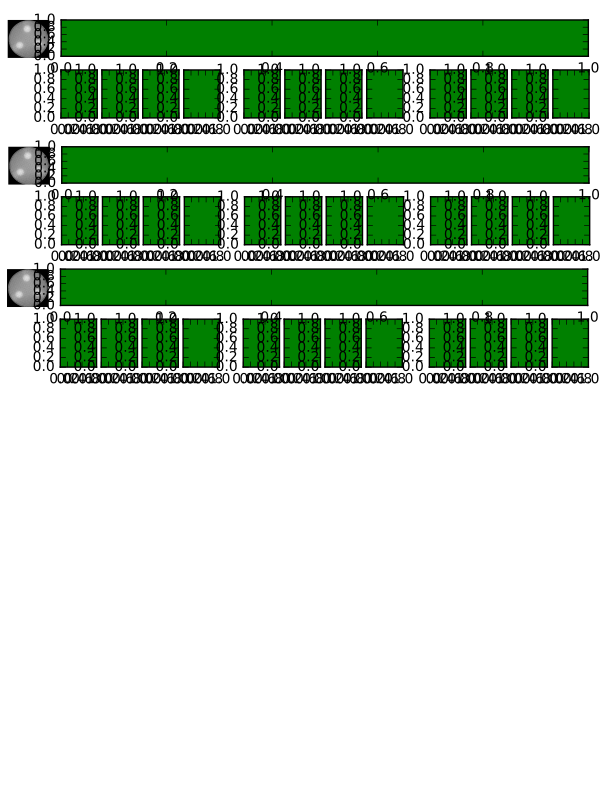

In [10]:
#Group axes example
layout = fifi.FigureLayout('group_axes_layout.svg')
layout.make_mplfigures()
layout.insert_figures()
layout.write_svg('group_axes_test_output.svg')
plt.close('all')
display(SVG('group_axes_test_output.svg'))

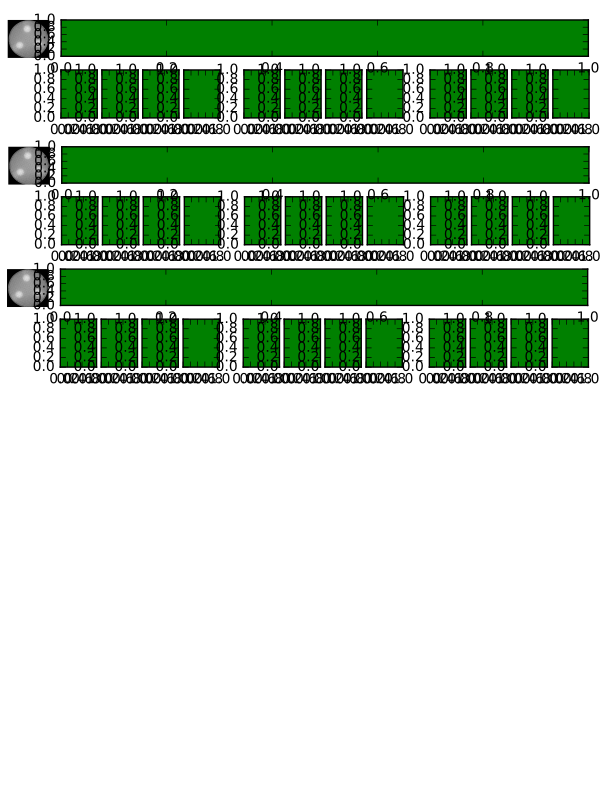

In [12]:
#Groups and figures example
layout = fifi.FigureLayout('multi_figures_layout.svg')
mplfig = layout.make_mplfigures()
layout.append_figure_to_layer(layout.figures.values()[0],'mpl_layer_2')
layout.append_figure_to_layer(layout.figures.values()[1],'mpl_layer_3')
layout.append_figure_to_layer(layout.figures.values()[2],'mpl_layer_4')
layout.write_svg('multi_fig_test_output.svg')
plt.close('all')
display(SVG('multi_fig_test_output.svg'))

# Using pathspec and patchspec

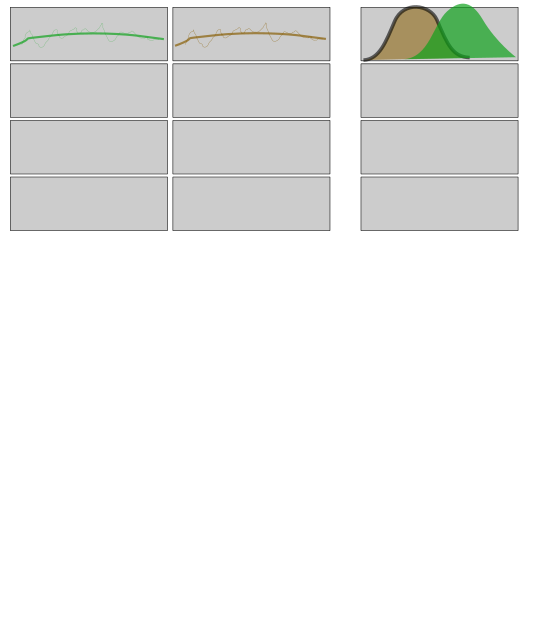

In [13]:
#this is the layout file
display(SVG('pathspec_layout.svg'))

In [14]:
# we collect some data
groupA_mean = 1.5
groupA_sigma = 1.0
groupB_mean = 0.3
groupB_sigma = 0.6
c1_effect = 0.3
c2_effect = 2.0
c3_effect = 0.0
c4_effect = 0.0

data = dict()

N = 500
T = 1.
Delta = T/N
for group_name,group_mean,group_sigma in zip(['A','B'],
                                             [groupA_mean,groupB_mean],
                                             [groupA_sigma,groupB_sigma]):
    data[group_name] = dict()
    for cond_name,cond_effect in zip(['cond_1','cond_2','cond_3','cond_4'],
                                     [c1_effect,c2_effect,c3_effect,c4_effect]):
        data[group_name][cond_name] = list()
        for trial in range(10):
            W = np.zeros(N+1)
            t = np.linspace(0, T, N+1);
            W[:N+1] = cond_effect + group_mean + np.cumsum(np.sqrt(Delta) *
                                                            np.random.standard_normal(N+1) *
                                                            group_sigma)
            t = np.linspace(0, T, N+1);
            data[group_name][cond_name].append(W)

In [15]:
#to remove spines
def kill_spines(ax):
    return fifi.mpl_functions.adjust_spines(ax,'none', 
                  spine_locations={}, 
                  smart_bounds=True, 
                  xticks=None, 
                  yticks=None, 
                  linewidth=1)

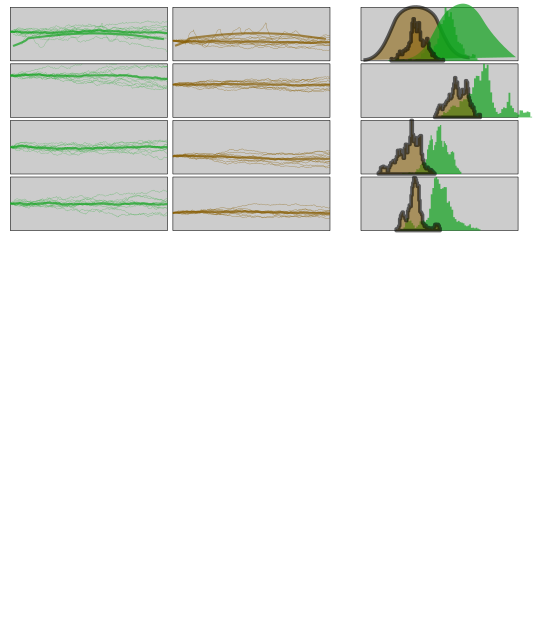

In [20]:
#to remove spines
def kill_spines(ax):
    return fifi.mpl_functions.adjust_spines(ax,'none', 
                  spine_locations={}, 
                  smart_bounds=True, 
                  xticks=None, 
                  yticks=None, 
                  linewidth=1)

## create a layout
layout = fifi.FigureLayout('pathspec_layout.svg')
## make the mpl figure objects
mplfig = layout.make_mplfigures()
## load the line and path specs to get plotting colors and effects
layout.load_pathspecs()
## iterate through what you want to plot and find the needed data,
## not the other way around..
for group_name,group in layout.axes_groups.items():
    if not(group_name == 'summary'):
        for cond_name,cond_ax in group.items():
            group_letter = group_name.split('group')[1]
            kwargs = layout.pathspecs['trial_%s'%group_letter].mplkwargs()
            cond_ax['axis'].plot(np.array(data[group_letter][cond_name]).T,**kwargs)
            
            kill_spines(cond_ax['axis'])
            kwargs = layout.pathspecs['mean_%s'%group_letter].mplkwargs()
            cond_ax['axis'].plot(np.mean(np.array(data[group_letter][cond_name]).T,axis = 1)
                                 ,**kwargs)
            cond_ax['axis'].set_ybound(-2,5)
    else:
        group_letter = 'A'
        kwargs = layout.pathspecs['hist%s'%group_letter].mplkwargs()
        for cond_name,cond_ax in group.items():
            cond_ax['axis'].hist(np.array(data[group_letter][cond_name]).ravel(),
                                 bins = 50,histtype = 'stepfilled',clip_on = False,**kwargs)
            cond_ax['axis'].set_xbound(-2,5)
            kill_spines(cond_ax['axis'])
        group_letter = 'B'
        kwargs = layout.pathspecs['hist%s'%group_letter].mplkwargs()
        for cond_name,cond_ax in group.items():
            cond_ax['axis'].hist(np.array(data[group_letter][cond_name]).ravel(),
                                 bins =50,histtype = 'stepfilled',clip_on = False,**kwargs)
            cond_ax['axis'].set_xbound(-2,5)
            kill_spines(cond_ax['axis'])

## insert the figures into the layout and save
layout.insert_figures()
layout.write_svg('pathspec_test_output.svg')
plt.close('all')
display(SVG('pathspec_test_output.svg'))

In [17]:
kwargs

{'edgecolor': array([[ 0.,  0.,  0.,  0.]]),
 'facecolor': array([[ 0.05490196,  0.63529412,  0.10588235,  0.68627451]]),
 'lw': 0.55703170374637}

# Complete example